## This notebook investigates the timing of jerks globally

In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
#sys.path.append( os.path.abspath('..') ) #This line needs to point to where-ever the jerks module has been compiled.
#from jerks import jerks

In [2]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [3]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [4]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [5]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

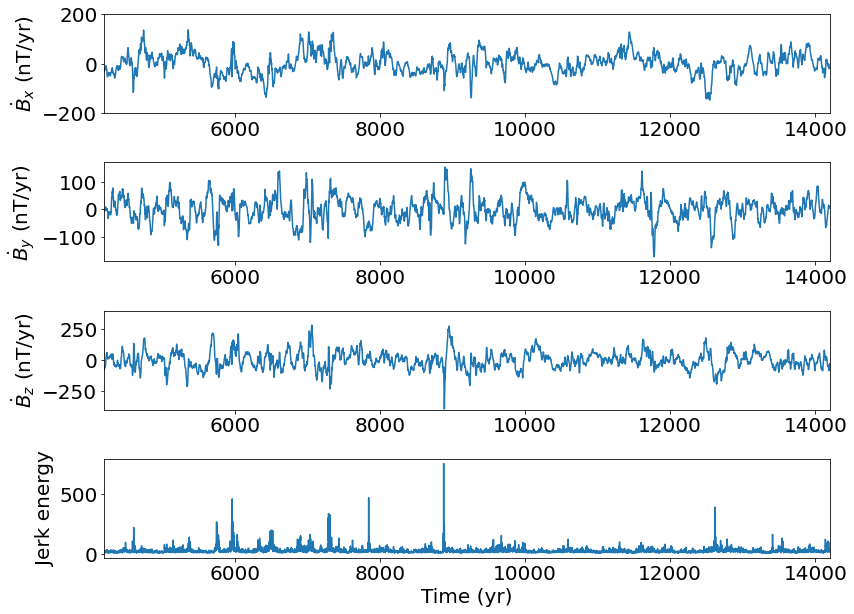

In [6]:
# Plot an example timeseries for whole duration
import chaosmagpy as cp

# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
radius = 6371.
theta = 90
phi = 45

# sample every year
time_yearly = np.arange(int(time.min()), int(time.max())+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,10) )
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlim(time_yearly.min(), time_yearly.max())
a=200
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
#ax2.set_ylim(-200,200)
ax2.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlim(time_yearly.min(), time_yearly.max())

#ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.set_xlim(time_yearly.min(), time_yearly.max())

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax4.set_ylabel('Jerk energy',fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax4.set_xlabel('Time (yr)',fontsize=20)
ax4.set_xlim(time_yearly.min(), time_yearly.max())

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Theta90_phi45_SV_timeseries.pdf')


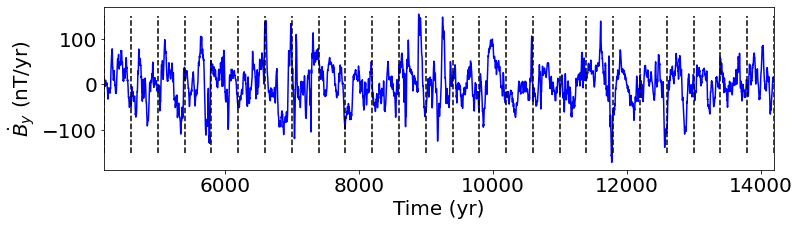

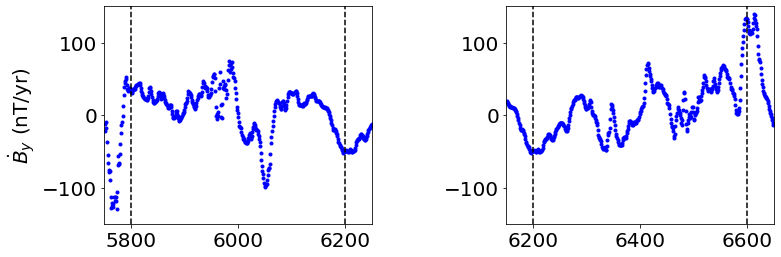

In [7]:
### Figure to show how the timeseries are stitched together
# Plot an example timeseries for whole duration

# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
radius = 6371.
theta = 90
phi = 45

# sample every year
time_yearly = np.arange(int(time.min()), int(time.max())+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)

starttime = time_yearly.min()
sectiontime = 400
overlap = 50

fig, ax = plt.subplots(1,1,figsize=(12,3) )
ax.plot( time_yearly,By_dot,'b' )
ax.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax.set_xlabel('Time (yr)',fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(time_yearly.min(), time_yearly.max())    
endtime = starttime + sectiontime
ax.vlines(starttime, -150,150, 'k', linestyle='dashed')
while endtime <= time_yearly.max():
    ax.vlines(endtime, -150,150, 'k', linestyle='dashed')
    endtime+= sectiontime
fig.savefig('Theta90_phi45_phi_component_decomposed_timeseries.pdf')

                       
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4)) 
starttime += 4 * sectiontime
sectiontime = 400
overlap = 50
mask = (starttime-overlap < time_yearly) & (time_yearly < starttime+sectiontime+overlap)
ax1.plot( time_yearly[mask],By_dot[mask],'b.' )

mask = (starttime+sectiontime-overlap < time_yearly) & (time_yearly < starttime+2*sectiontime + overlap)
ax2.plot( time_yearly[mask],By_dot[mask],'b.' )


#ax2.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlim(starttime - overlap , starttime +  sectiontime + overlap)
ax2.set_xlim(starttime +sectiontime - overlap, starttime + 2 * sectiontime + overlap)

ax1.set_ylim(-150,150)
ax2.set_ylim(-150,150)
ax1.vlines(starttime, -150,150, 'k', linestyle='dashed')
ax1.vlines(starttime + sectiontime, -150,150, 'k', linestyle='dashed')
ax2.vlines(starttime+sectiontime, -150,150, 'k', linestyle='dashed')
ax2.vlines(starttime + 2*sectiontime, -150,150, 'k', linestyle='dashed')

ax1.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

plt.savefig('Theta90_phi45_phi_component_split_timeseries.pdf')


#### Load the ensembles from HPC run created by Python script

In [257]:
import pickle

Nsample = 1  #1M samples
SV_error = 10
resolution = 5
filename = "../ensemble_diagnostics/Jerks_{1:1d}x{1:1d}_{0:1d}M.results".format(Nsample,resolution)

with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, \
    relative_sigmas, window_start, window_end, window_length, \
    overlap, thetas, phis] = pickle.load(fp)
# get results
    results = pickle.load(fp)

# The entries have the format:
# [theta,phi,0,jerks_info
# theta, phi,1,jerks_info
# theta, phi,2,jerks_info

# where (theta,phi) is the position
# i is the component (0=x, 1=y, 2=z)
# jerks_info is the list of jerk information

print( [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, \
    relative_sigmas, window_start, window_end, window_length, \
    overlap, thetas, phis] )


[10, 0, 100, 100, 10000, 1010000, array([0.08, 0.02, 0.08]), array([ 4200,  4600,  5000,  5400,  5800,  6200,  6600,  7000,  7400,
        7800,  8200,  8600,  9000,  9400,  9800, 10200, 10600, 11000,
       11400, 11800, 12200, 12600, 13000, 13400, 13800]), array([ 4600,  5000,  5400,  5800,  6200,  6600,  7000,  7400,  7800,
        8200,  8600,  9000,  9400,  9800, 10200, 10600, 11000, 11400,
       11800, 12200, 12600, 13000, 13400, 13800, 14200]), 400, 50, array([ 10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
        65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170.]), array([-180., -175., -170., -165., -160., -155., -150., -145., -140.,
       -135., -130., -125., -120., -115., -110., -105., -100.,  -95.,
        -90.,  -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,
        -45.,  -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,
          0.,    5.,   10.,   15.

In [194]:
time.min(), time.max(), 10000/400

(4200.0, 14200.0, 25.0)

In [72]:
# Plot jerk occurance at selected location

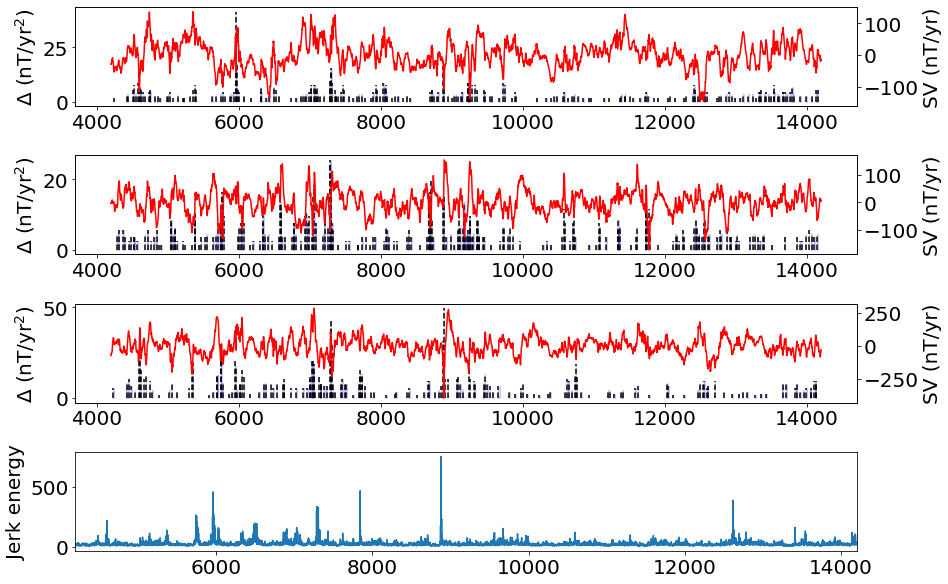

In [196]:
import matplotlib.colors as colors

radius = 6371.
theta = 90
phi = 45

# sample every year
time_yearly = np.arange(int(time.min()), int(time.max())+1)
TIMES_MIN = int(time.min())
TIMES_MAX = int(time.max())
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)

import matplotlib.colors as colors
ax=4*[0]
fig, ax = plt.subplots( 4,1, figsize=(14,10))    


for jerk in results:
    # check location
    theta_loc = jerk[0]
    phi_loc=jerk[1]
    if abs( theta - theta_loc) < 1e-6  and abs(phi - phi_loc) < 1e-6:
        for i in [0,1,2]:
            if i == 0:
                offset = 3
            elif i == 1:
                offset = 7
            else:
                offset = 11
                
        
            ymin = 0
            ymax = max(event[1] for event in jerk[offset])
            for event in jerk[offset]:
                ax[i].vlines(event[0], ymin, abs(event[1]), colors='k',linestyles='dashed')
                ax[i].fill_betweenx([ymin, abs(event[1])], event[2], event[3],alpha=0.15, color='blue')
            axb = ax[i].twinx()
            if i == 0:
                axb.plot(time_yearly, Bx_dot, 'r')
            elif i == 1:
                axb.plot(time_yearly, By_dot, 'r')
            else:
                axb.plot(time_yearly, Bz_dot, 'r')

            axb.tick_params(axis='both', which='major', labelsize=20)
            axb.set_ylabel('SV (nT/yr)',fontsize=20)

            ax[i].tick_params(axis='both', which='major', labelsize=20)
            ax[i].set_ylabel('$\Delta$ (nT/yr$^2$)',fontsize=20)

ax[-1].set_xlim(TIMES_MIN, TIMES_MAX)
ax[-1].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
ax[-1].tick_params(axis='both', which='major', labelsize=20)
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[-1].plot(time_EJ, EJ )
ax[-1].set_xlim(TIMES_MIN, TIMES_MAX )
#ax[3].set_title('Jerk energy')
ax[-1].set_ylabel('Jerk energy',fontsize=20)
ax[-1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('SV_jerks_whole_timeseries.pdf')


In [9]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [258]:
def plot_map(time_min, time_max, thetas, phis, jerks, coeffs, time, component = 2, max_scale=40, normalise=False, save_name=False, max_Delta = 100):
    ''' Plot a map of the jerks that occured in a given time interval
    
    Inputs:
    time_min, time_max:  the time window over which to plot
    component: 0,1,2 (for Bx, By, Bz) respectively
    max_scale: the maximum scale
    jerks: a list of jerk information
    normalise: either False, or [norm_start_time, norm_end_time]
    coeffs, time: the model coefficients (used for normalisation)
    save_name: False, or the name of the file for saving
    max_Delta: the maximum amplitude to qualify for a jerk. Setting this to a low number removes strong events.
    Outputs:
    
    Creates a plot of the maximum Delta within [time_min, time_max].
    Optionally, for each location, these values are scaled by the range (max-min) SV over the window [norm_start_time, norm_end_time] 
    '''
    
    

    data = np.zeros(( phis.shape[0], thetas.shape[0]))
    for jerk in jerks:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        theta = jerk[0]
        phi=jerk[1]
        
        theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
        data[phi_index,theta_index] = 0
        for event in jerk[offset]:
            if (event[0] > time_min) and (event[0] < time_max) and (abs(event[1]) < max_Delta):
                data[phi_index,theta_index] = max(data[phi_index,theta_index],abs(event[1] ))
            
        if normalise != False:
            import chaosmagpy as cp
            radius = 6371.
            norm_start_time, norm_end_time = normalise[0], normalise[1]
            time_yearly = np.arange(norm_start_time, norm_end_time)
            Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
            Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
            Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
            if component == 0:
                data[phi_index,theta_index] /= max(abs(Bx_dot.max()), abs(Bx_dot.min()) )
            elif component == 1:
                data[phi_index,theta_index] /= max(abs(By_dot.max()), abs(By_dot.min()) )
            else:
                data[phi_index,theta_index] /= max(abs(Bz_dot.max()), abs(Bz_dot.min()) )
        
        
    
    
    f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
    
        
    if normalise != False:
        max_scale = max(abs(data.max()), abs(data.min() )) 
    
    marker_size = 11. 

    import matplotlib.cm as cm
    my_cmap = cm.get_cmap("viridis_r").copy()
    my_cmap.set_under('w')
    
    #cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
    #axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
    pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=1, vmax=max_scale, transform=ccrs.PlateCarree())
    #gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
    #              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    
    axes.coastlines()
    
    axes.top_labels = False
    axes.right_labels = False
    axes.xlines = False
    axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
    axes.xformatter = LONGITUDE_FORMATTER
    axes.yformatter = LATITUDE_FORMATTER

    clb = plt.colorbar(pc, ax=axes, shrink=0.3)
    clb.set_label(r'$\Delta (nT/yr^2$)', fontsize=20)
    clb.ax.tick_params(labelsize=20)


    if save_name != False:
        f.savefig(save_name, bbox_inches='tight')


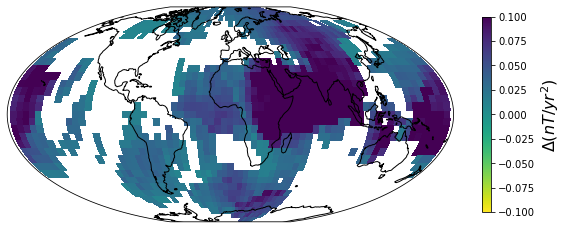

In [117]:
plot_map(8880, 8880+20, thetas, phis, results,coeffs, time, component = 2, max_scale=20, normalise=[8000,9000])

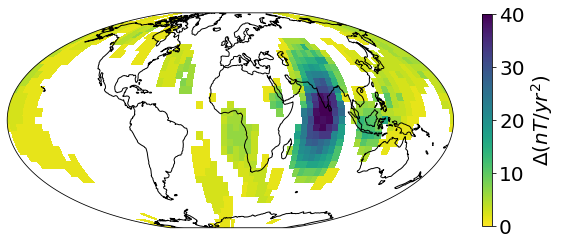

In [66]:
plot_map(jerk_times[0]-10, jerk_times[0]+10, thetas, phis, results,coeffs, time, component = 1, max_scale=40, normalise = False, save_name = 'Jerk_event_1_Delta.pdf')

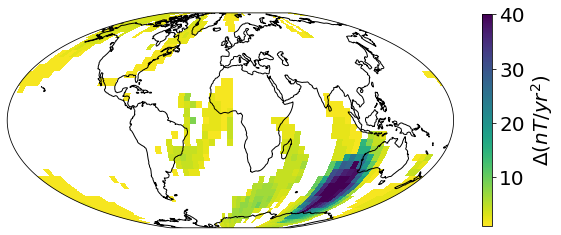

In [168]:
plot_map(jerk_times[7]-10, jerk_times[7]+10, thetas, phis, results,coeffs, time, component = 1, max_scale=40, normalise = False, save_name = 'Jerk_event_8_Delta.pdf')

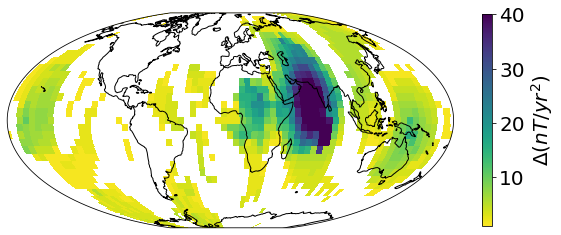

In [259]:
plot_map(jerk_times[8]-10, jerk_times[8]+10, thetas, phis, results,coeffs, time, component = 1, max_scale=40, normalise = False, save_name= 'Jerk_event_9_Delta.pdf')

In [63]:
# Find location of maximum Delta in a given window:
component = 1
time_min = 8880-10
time_max = 8880+10
data = np.zeros(( phis.shape[0], thetas.shape[0]))
for jerk in results:
    if component == 0:
        offset = 3
    elif component == 1: 
        offset = 7
    else:
        offset = 11
        
    theta = jerk[0]
    phi=jerk[1]

    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
    data[phi_index,theta_index] = 0
    for event in jerk[offset]:
        if (event[0] > time_min) and (event[0] < time_max):
            data[phi_index,theta_index] = max(data[phi_index,theta_index],abs(event[1] ))
locs = np.unravel_index(data.argmax(), data.shape)
print('Max Delta in time window is {0:3.1f} at theta {1:f}, phi {2:f}'\
      .format( data.max(), thetas[locs[1]], phis[locs[0]] ) )

Max Delta in time window is 49.5 at theta 80.000000, phi 60.000000


In [64]:
def plot_interactive( t ):
    plot_map(window_start[0] + t-10, window_start[0] + t+10, thetas, phis, results, coeffs, time, component = 2, max_scale=40)

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

interactive_plot = interactive(plot_interactive, t=(0,3000) )
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=1500, description='t', max=3000), Output(layout=Layout(height='350px')))…

In [175]:
# Make movie of jerks in a moving window

component = 1
jerks = results

import numpy as np
import matplotlib.pyplot as plt


# Assemble a discretised structure (theta, phi, time) showing the jerk occurence:
time_window_span = 20

times_centred = np.arange( time.min(), time.max()-time_window_span/2, time_window_span) + time_window_span/2

data_movie = np.zeros(( phis.shape[0], thetas.shape[0], times_centred.shape[0] ))
for jerk in jerks:
    if component == 0:
        offset = 3
    elif component == 1: 
        offset = 7
    else:
        offset = 11
    theta = jerk[0]
    phi=jerk[1]

    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
    data_movie[phi_index,theta_index] = 0
    for event in jerk[offset]:
        for event_index, event_time in enumerate(times_centred):
            if (event[0] > event_time-time_window_span/2) and (event[0] < event_time + time_window_span/2):
                data_movie[phi_index,theta_index, event_index] = max(data_movie[phi_index,theta_index, event_index],abs(event[1] ))
            

In [176]:
# Now write the movie frame by frame to disk
%matplotlib inline
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

directory_name = 'jerks_movie_component1'
import os

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    
for frame_index in range(data_movie.shape[2]):
    f, axes = plt.subplots(nrows=1, ncols=1,figsize=(13,4), subplot_kw={'projection': ccrs.Mollweide() }) 
    
# Need to set a threshold of 1 (and colour white for all values under this), otherwise cartopy doesn't always properly give the outline of the Earth's surface

    import matplotlib.cm as cm
    my_cmap = cm.get_cmap("viridis_r").copy()
    my_cmap.set_under('w')

    max_scale = 40
    pc = axes.pcolormesh(phis, 90. - thetas, data_movie[:,:,frame_index].T, cmap=my_cmap,vmin=1, vmax=max_scale, transform=ccrs.PlateCarree())

    
    axes.coastlines()
    
    axes.top_labels = False
    axes.right_labels = False
    axes.xlines = False
    axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
    axes.xformatter = LONGITUDE_FORMATTER
    axes.yformatter = LATITUDE_FORMATTER

    clb = plt.colorbar(pc, ax=axes )
    clb.set_label(r'$\Delta (nT/yr^2$)', fontsize=20)
    clb.ax.tick_params(labelsize=20)
    f.suptitle("Time {0:3.1f}".format( times_centred[frame_index]), fontsize=22)
    f.savefig(os.path.join(directory_name,'frame{0:06d}.png'.format(frame_index)), dpi=400)#,bbox_inches='tight')
    plt.close()
    


In [179]:
if os.path.exists(os.path.join(directory_name, 'jerk_movie.mp4')):
    os.remove(directory_name + '/jerk_movie.mp4')
os.system('ffmpeg  -framerate 5 -pattern_type glob -i ' + directory_name + '/"frame*.png"  -c:v libx264 -pix_fmt yuv420p -s 1920x1080 ' + directory_name+'/jerk_movie.mp4')

ffmpeg version N-105436-g98cef1ebbe-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

0

#### Find regions with large/small jerks 

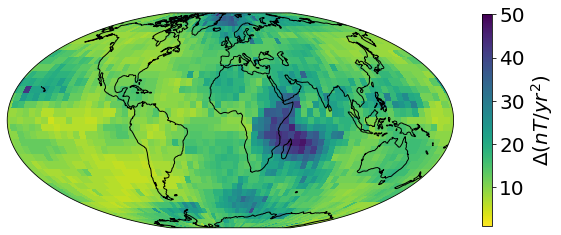

In [235]:
plot_map(window_start[0], window_end[-1], thetas, phis, results, coeffs, time,\
    component = 0, max_scale=50, save_name='Max_activity_cmpt0.pdf')

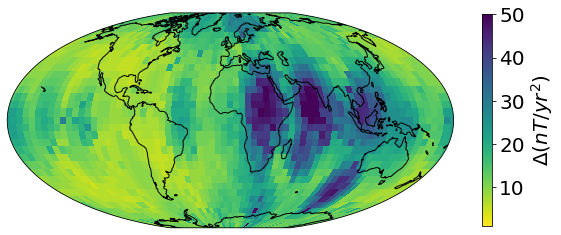

In [234]:
plot_map(window_start[0], window_end[-1], thetas, phis, results, coeffs, time,\
    component = 1, max_scale=50, save_name='Max_activity_cmpt1.pdf')

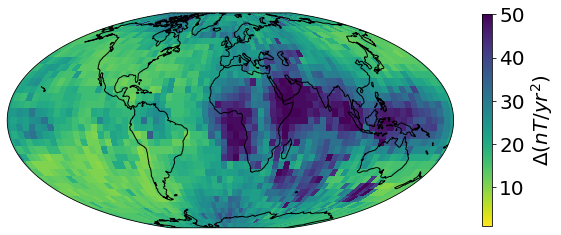

In [233]:
plot_map(window_start[0], window_end[-1], thetas, phis, results, coeffs, time,\
    component = 2, max_scale=50, save_name='Max_activity_cmpt2.pdf')

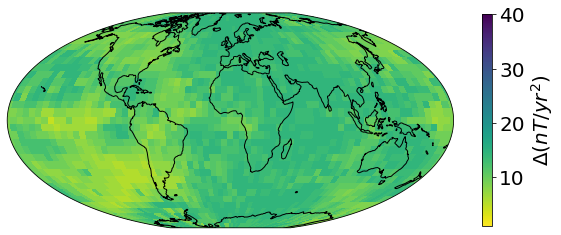

In [325]:
plot_map(window_start[0], window_end[-1], thetas, phis, results, coeffs, time,\
    component = 0, max_scale=40, max_Delta=15, save_name='Max_activity_cmpt0_max_Delta_15.pdf')

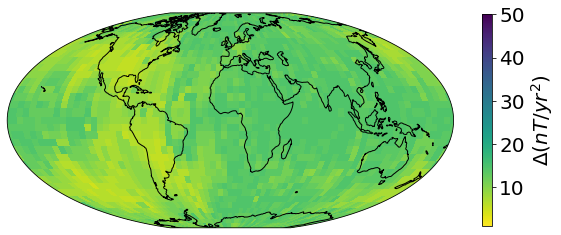

In [231]:
plot_map(window_start[0], window_end[-1], thetas, phis, results, coeffs, time,\
    component = 1, max_scale=50, max_Delta=15, save_name='Max_activity_cmpt1_max_Delta_15.pdf')

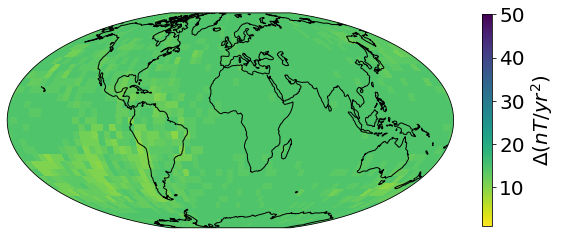

In [232]:
plot_map(window_start[0], window_end[-1], thetas, phis, results, coeffs, time,\
    component = 2, max_scale=50, max_Delta=15, save_name='Max_activity_cmpt2_max_Delta_15.pdf')

In [74]:
#### Find the average amplitude of jerks

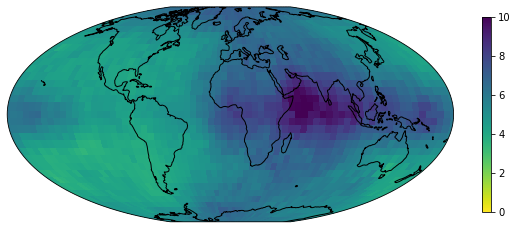

In [200]:
component = 2
max_scale = 10
data = np.zeros(( phis.shape[0], thetas.shape[0]))
for jerk in results:
    if component == 0:
        offset = 3
    elif component == 1: 
        offset = 7
    else:
        offset = 11
    theta = jerk[0]
    phi=jerk[1]
        
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
    
    data[phi_index,theta_index] = 0
    count = 0
    for event in jerk[offset]:
        data[phi_index,theta_index] += abs(event[1])
        count += 1
    data[phi_index,theta_index] = data[phi_index,theta_index] / count
        
f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 
marker_size = 11. 

pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap='viridis_r',vmin=0, vmax=max_scale, transform=ccrs.PlateCarree())
axes.coastlines()
clb = plt.colorbar(pc, ax=axes, shrink=0.30)

           

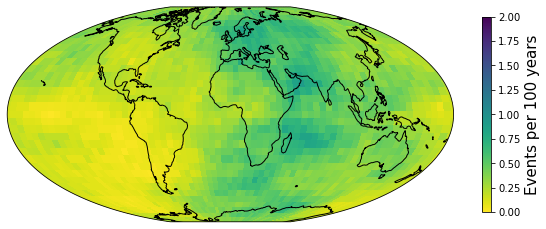

In [371]:
# Find jerk density in time
upper_threshold = 50
lower_threshold = 5

component = 0
max_scale = 2
data = np.zeros(( phis.shape[0], thetas.shape[0]))
for jerk in results:
    if component == 0:
        offset = 3
    elif component == 1: 
        offset = 7
    else:
        offset = 11
    theta = jerk[0]
    phi=jerk[1]
        
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
    
    data[phi_index,theta_index] = 0
    count = 0
    for event in jerk[offset]:
        if (abs(event[1]) > lower_threshold) and (abs(event[1]) < upper_threshold):
            count += 1
    data[phi_index,theta_index] = count / (window_end[-1] - window_start[0]) * 100
        
f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 
marker_size = 11. 

pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap='viridis_r',vmin=0, vmax=max_scale, transform=ccrs.PlateCarree())
axes.coastlines()
clb = plt.colorbar(pc, ax=axes, shrink=0.30)
clb.set_label('Events per 100 years', fontsize=15)
f.savefig('Events_per_century_min_{0:3.1f}_max_{1:3.1f}_cmpt_{2:d}.pdf'.format(lower_threshold,upper_threshold,component),bbox_inches='tight')
           

Mean, median jerk amplitude for Bx is 3.6 nT/yr^2, 2.5 nT/yr^2
Mean, median jerk amplitude for By is 3.7 nT/yr^2, 2.5 nT/yr^2
Mean, median jerk amplitude for Bz is 5.8 nT/yr^2, 4.5 nT/yr^2


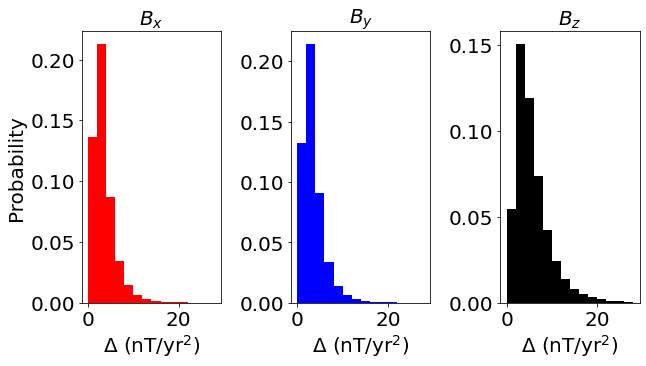

In [466]:
# histogram of jerk amplitude:
jerk_data0, jerk_data1, jerk_data2 = [],[],[]
for jerk in results:

    for event in jerk[3]:
        jerk_data0.append(abs(event[1]))
    for event in jerk[7]:
        jerk_data1.append(abs(event[1])) 
    for event in jerk[11]:
        jerk_data2.append(abs(event[1]))
fig, (ax0,ax1, ax2) = plt.subplots(1,3, figsize=(10,5))
ax0.hist(jerk_data0, bins=np.arange(0,30,2),color='red',density=True)
ax1.hist(jerk_data1, bins=np.arange(0,30,2),color='blue',density=True)
ax2.hist(jerk_data2, bins=np.arange(0,30,2),color='black', density=True )
ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax0.set_xlabel('$\Delta$ (nT/yr$^2$)',fontsize=20)
ax1.set_xlabel('$\Delta$ (nT/yr$^2$)',fontsize=20)
ax2.set_xlabel('$\Delta$ (nT/yr$^2$)',fontsize=20)


ax0.set_ylabel('Probability',fontsize=20)
ax0.set_title('$B_x$',fontsize=20)
ax1.set_title('$B_y$',fontsize=20)
ax2.set_title('$B_z$',fontsize=20)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
fig.savefig('Jerk_amplitude_histogram.pdf',bbox_inches='tight')

print('Mean, median jerk amplitude for Bx is {0:3.1f} nT/yr^2, {1:3.1f} nT/yr^2'.format( np.mean(jerk_data0), np.median(jerk_data0)))
print('Mean, median jerk amplitude for By is {0:3.1f} nT/yr^2, {1:3.1f} nT/yr^2'.format( np.mean(jerk_data1), np.median(jerk_data1)))
print('Mean, median jerk amplitude for Bz is {0:3.1f} nT/yr^2, {1:3.1f} nT/yr^2'.format( np.mean(jerk_data2), np.median(jerk_data2)))


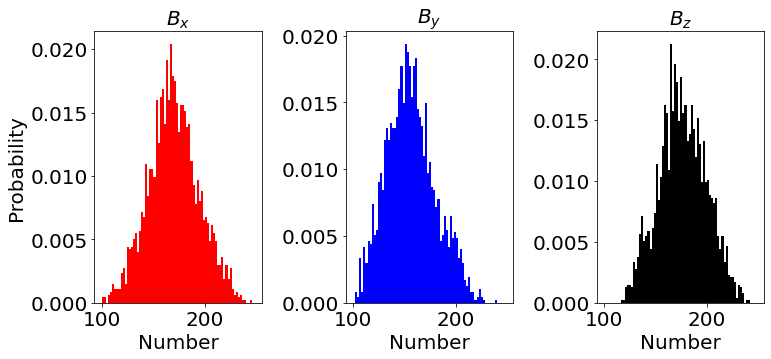

In [458]:
# histogram of number of jerks:
jerk_data0, jerk_data1, jerk_data2 = [],[],[]
for jerk in results:
    jerk_data0.append(len(jerk[3]))
    jerk_data1.append(len(jerk[7]))
    jerk_data2.append(len(jerk[11]))
    
fig, (ax0,ax1, ax2) = plt.subplots(1,3, figsize=(12,5))
ax0.hist(jerk_data0, bins=np.arange(100,250,2),color='red',density=True)
ax1.hist(jerk_data1, bins=np.arange(100,250,2),color='blue',density=True)
ax2.hist(jerk_data2, bins=np.arange(100,250,2),color='black', density=True )
ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax0.set_xlabel('Number',fontsize=20)
ax1.set_xlabel('Number',fontsize=20)
ax2.set_xlabel('Number',fontsize=20)


ax0.set_ylabel('Probability',fontsize=20)
ax0.set_title('$B_x$',fontsize=20)
ax1.set_title('$B_y$',fontsize=20)
ax2.set_title('$B_z$',fontsize=20)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
fig.savefig('Jerk_number_histogram.pdf',bbox_inches='tight')


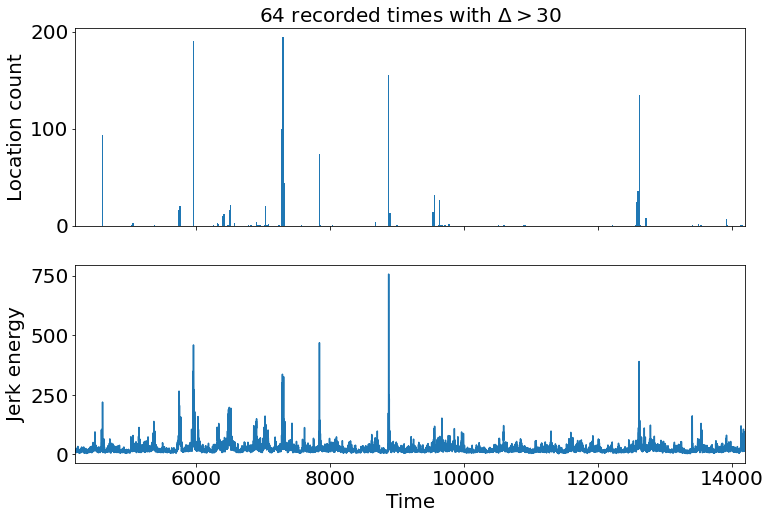

In [451]:
# Find when the jerks occurred by producing a bar chart of the number of events within binned windows over the surface

component = 2
max_count = 5

upper_threshold = 100
lower_threshold = 30
jerk_window_length = 20

jerk_window_centres = np.arange(int(time.min()), int(time.max()), jerk_window_length)

# data is either 0 or 1, depending on whether a jerk occurred at a certain location in a certain window.
data = np.zeros(( phis.shape[0], thetas.shape[0],3, jerk_window_centres.shape[0]), dtype=int)
data[:,:,:,:] = 0
for component in [0,1,2]:
    for jerk in results:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        theta = jerk[0]
        phi=jerk[1]

        theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

        for event in jerk[offset]:
            if (abs(event[1]) > lower_threshold) and (abs(event[1]) < upper_threshold):
                time_index = abs(event[0] - jerk_window_centres).argmin()
                data[phi_index,theta_index,component,time_index] = 1

fig,(ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(12,8) )
ax1.bar(jerk_window_centres, data.sum(axis=0).sum(axis=0).sum(axis=0),align='center',width=jerk_window_length )
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax1.set_ylabel('Location count', fontsize=20)
ax1.set_title(r'{1:d} recorded times with $\Delta > ${0:d}'.\
              format(lower_threshold, np.count_nonzero(data.sum(axis=0).sum(axis=0).sum(axis=0))),fontsize=20)
ax2.set_xlabel('Time', fontsize=20)
ax2.set_ylabel('Jerk energy', fontsize=20)
ax1.set_xlim( time.min(), time.max() )
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax2.plot(time_EJ, EJ )
fig.savefig('Jerk_timing_global_min_Delta_{0:d}.pdf'.format(lower_threshold),bbox_inches='tight')



In [450]:
thetas.shape[0], phis.shape[0]

(33, 72)

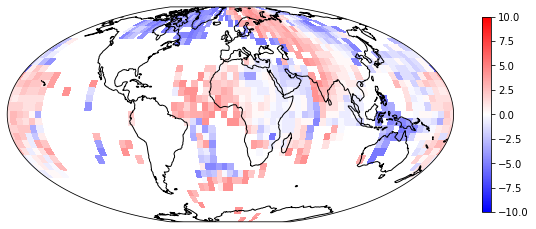

In [153]:
plot_jerk_time_map(8880, 8880+10, thetas, phis, results, component = 2, max_scale=10)

In [ ]:
# Make plot of which component jerks first

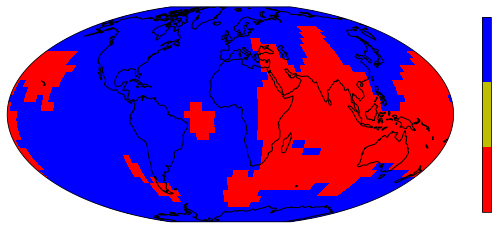

In [172]:
from matplotlib.pyplot import *

times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
jerk_times = np.zeros( (slopes.shape[0], slopes.shape[1],3), dtype=float)

for component in range(3):

    (phi_grid,theta_grid), slopes = find_slope_change(results, component = component, 
                                type = 'median_grad', times=times_for_model , normalise = 'meanSV')
    threshold = 0.3
    for i in range(slopes.shape[0]):
        for j in range(slopes.shape[1]):
            jerk_times[i,j] = times_for_model[slopes[i,j,:].argmax() ]
            if slopes[i,j,:].max() < threshold:
                jerk_times[i,j,component] = 'NaN'
    jerk_min_time =  8880

jerk_colour = np.zeros( (slopes.shape[0], slopes.shape[1],3), dtype=int)
jerk_colour = np.argmin(jerk_times,axis=2)
            
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 
marker_size = 11. 

#cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
#axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
discrete   = matplotlib.colors.ListedColormap( [ 'r', 'y', 'b' ] )
pc = axes.pcolormesh(phi_grid, 90. - theta_grid, jerk_colour[:,:], cmap=discrete,vmin = 0, vmax=2, transform=ccrs.PlateCarree())
#gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
#              linewidth=2, color='gray', alpha=0.5, linestyle='--')

axes.coastlines()
#axes.set_title('Delta at time {0:f}'.format(times[time_index]) )
axes.top_labels = False
axes.right_labels = False
axes.xlines = False
axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
axes.xformatter = LONGITUDE_FORMATTER
axes.yformatter = LATITUDE_FORMATTER

clb = plt.colorbar(pc, ax=axes, shrink=0.30, boundaries = [0,1,2],ticks=[] )


In [160]:
np.where(jerk_colour == 1)

(array([], dtype=int64), array([], dtype=int64))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

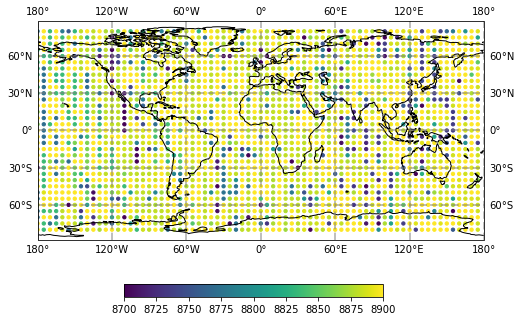

In [38]:
def find_jerk_time():
    ntheta = 33
    nphi = 72
    phis = np.linspace(-180, 180 , nphi, endpoint=False, dtype=float)
    thetas = np.linspace(-80,80, ntheta, endpoint=True, dtype=float) + 90.
# create an array in which to stack the components and find the max time.
    delta_array = np.zeros((thetas.shape[0], phis.shape[0], time_intervals_edges.shape[0]-1),dtype=float)
    jerk_time = np.zeros((thetas.shape[0], phis.shape[0]),dtype=float)
# cycle through results 
    for j in range(len(results)):
        theta_index = np.where(thetas==results[j][0])[0][0]
        phi_index = np.where(phis == results[j][1] )[0][0]
# add all components
        delta_array[theta_index,phi_index,:] += results[j][4][:] + results[j][9][:] + results[j][14][:]
        #if( (theta_index == 13) and (phi_index == 45)):
        #    print( results[j][4][:] ) 
        #    print('')
        #print( theta_index, phi_index)
    for i in range(len(thetas)):
        for j in range(len(phis)):
            time_index = delta_array[i,j,:].argmax()
            jerk_time[i,j] = 0.5*(time_intervals_edges[time_index] + time_intervals_edges[time_index+1])
            if( (abs(thetas[i]-80.) < 1.0e-4) and (abs(phis[j]-65.) < 1e-4)):
                temp = (delta_array[i,j])
    
    return thetas, phis, jerk_time, temp   
    

    
thetas, phis , jerk_times, temp = find_jerk_time()
plt.figure()
a,b = np.meshgrid(thetas, phis)

plt.figure()
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,12),subplot_kw={'projection': ccrs.PlateCarree() }) 
marker_size = 11. 

cax = axes.scatter(b,90.-a, s = 11, c=jerk_times,cmap='viridis',vmin = 8700, vmax = 8900)
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axes.coastlines()
cb_ax = f.add_axes([0.20, 0.31, 0.6, 0.1])
    #cb_ax.scatter([0,1,2,3],[0,1,2,3],[0,1,2,4])
cbar = f.colorbar(cax, ax=cb_ax, orientation = 'horizontal')
cb_ax.set_axis_off()


80.0 65.0
8880.5


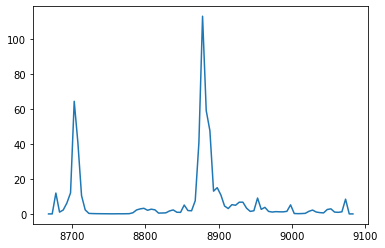

In [39]:
thetas, phis , jerk_times, temp = find_jerk_time()
plt.figure()
plt.plot( time_intervals_edges[:-1], temp)
print(thetas[14] ,phis[49])
print(jerk_times[14,49])


In [20]:
print( jerk_times.max() )

9075.5


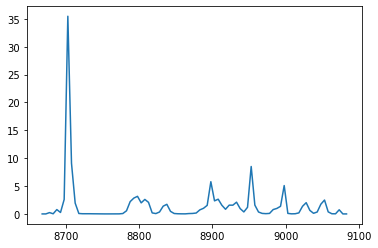

In [40]:
for j in range(len(results)):
    if( results[j][0] == 80. and results[j][1] == 65.) :
        a = results[j][4] 
plt.figure()
plt.plot(time_intervals_edges[:-1],a)

In [108]:
jerk_number = 8 # in Python indexing (i.e. event 9)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV

SV_errors = np.array([5,10,15,20])
num_SV_errors = SV_errors.shape[0]

discretise_size = 100
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=int )
Acceptance_rates_save = np.zeros( (num_SV_errors,len(run_components),4),dtype=float)

for error_j_index, error_j in enumerate(SV_errors):
    
    for run_component_index,i in enumerate(run_components):
        if i == 0:
            SV = Bx_dot
        elif i == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        delta_SV = error_j * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
        SV_MIN = -400
        SV_MAX = 400

        K_MIN = 0
        K_MAX = 100
        sigmas = np.array([20,10,20],dtype = float)
        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
        # sigma_change_value = sigmas(1)
        # sigma_move = sigmas(2)
        # sigma_birth = sigmas(3)

        THIN = 100
        NBINS = 100
        credible = 0.0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 2000000+burn_in
        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        CP_hist_save[error_j_index,run_component_index,:] = CP[:]
        delta_hist_save[error_j_index,run_component_index,:] = delta_slope[:]
        Acceptance_rates_save[error_j_index,run_component_index,:] = Acceptance_rates[:]
    

In [109]:
# Acceptance rates for SV errors, averaged over the vector components.

# The sigma parameters seem to generate acceptable acceptance ratios.
print(np.sum(Acceptance_rates_save[:,:,:]/Acceptance_rates_save.shape[1],axis=1))


[[28.27283287 16.45110003  3.93178105  3.94220352]
 [42.02626673 28.04337056  5.85369444  5.86995681]
 [49.56986872 34.85435677  6.93889523  6.95797205]
 [54.32329941 40.43412145  7.59780264  7.61879953]]


1

#### Stacked data:

<Figure size 432x288 with 0 Axes>

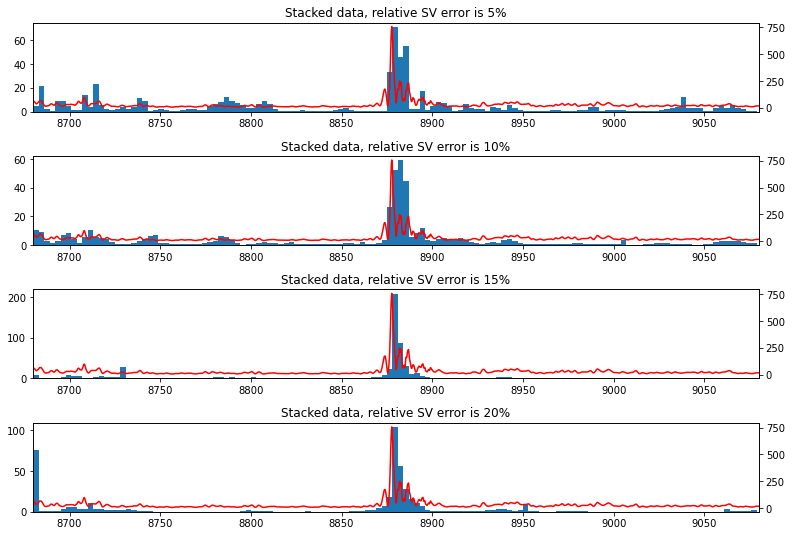

In [110]:
plt.figure()

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
fac = (NSAMPLE-burn_in)/THIN

for i in range(ax.shape[0]):
    ax[i].set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].bar(left_edges, np.sum(delta_hist_save[i,:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
    axb = ax[i].twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax[i].set_xlim(time_yearly.min(), time_yearly.max() )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




<Figure size 432x288 with 0 Axes>

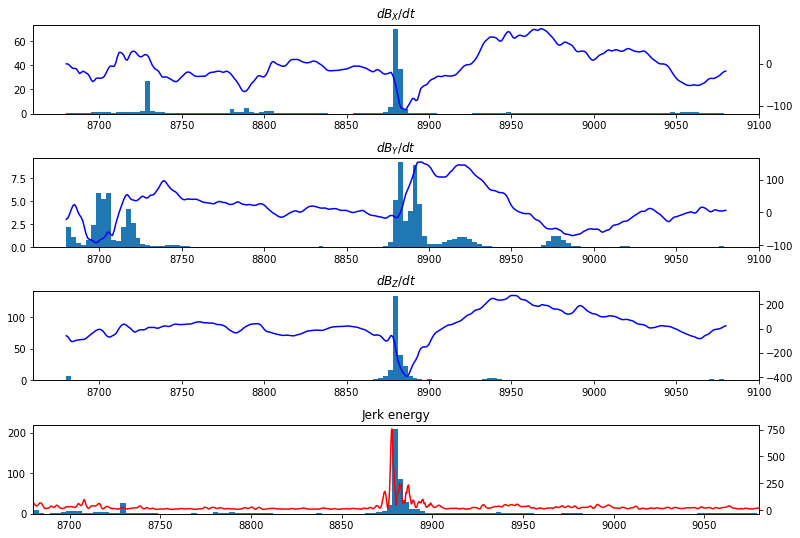

In [114]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
error_index = 2  #15% error
ax1.bar(left_edges, delta_hist_save[error_index,0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, delta_hist_save[error_index,1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, delta_hist_save[error_index,2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4b = ax4.twinx()
ax4.bar(left_edges, delta_hist_save[error_index,:,:].sum(axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax4b.plot(time_EJ, EJ,'r' )

ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Jerk time from delta slope or change point probability:

In [121]:
time_index_delta = np.argmax(np.sum(delta_hist_save[2,:,:],axis=0))
print('Jerk time from delta slope is {0:f}'.
      format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))


Jerk time from delta slope is 8879.500000


In [ ]:
# Animate time window for jerk 9
plt.close('all')
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

jerk_number = 8

# jerk times as defined in catalogue
jerk_times = [4605,5750,2920, 1915, 6450,7295,7620,7844,8878,9673,10593,12619,13412,13543]
# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)
t0 = jerk_times[jerk_number]
f_size = 16  # fontsize for figure

time_intervals_edges = np.arange(-210,211,20) + jerk_times[jerk_number]
Nsample = 100

filename = "../ensemble_diagnostics/Jerk{0:1d}_5x5_{1:d}M_20yr.results".format(jerk_number+1,Nsample)

with open(filename, "rb") as fp:   # Unpickling
     results = pickle.load(fp)

for l in range(0,21):
    
    y_theta, y_phi, y_delta = [],[],[]

    for j in range(len(results)):
        theta = results[j][0]
        phi = results[j][1]
        component = 1
        delta = results[j][9][l]  # this is the element that spans the event


        y_theta.append(theta)
        y_phi.append(phi)
    # normalise by average value at location:
        y_delta.append ( delta /np.mean(results[j][9] ))

    cmap = plt.get_cmap('viridis')
    plt.figure()

    f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,12),subplot_kw={'projection': ccrs.PlateCarree() }) 
    #y_delta = np.array(y_delta)
    marker_size = 11. 

    axes.set_title('Time bin ' + str(time_intervals_edges[l]) + '-' + str(time_intervals_edges[l+1]))
    cax = axes.scatter(y_phi,90.-np.array(y_theta), s = marker_size, c=y_delta,cmap=cmap, vmin=0, vmax=10)
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    axes.coastlines()

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    cb_ax = f.add_axes([0.20, 0.31, 0.6, 0.1])
    #cb_ax.scatter([0,1,2,3],[0,1,2,3],[0,1,2,4])
    cbar = f.colorbar(cax, ax=cb_ax, orientation = 'horizontal')
    cb_ax.set_axis_off()


    outfname = 'Jerk_delta_map_{0:d}_5x5_{1:d}M_timeindex{2:02d}'.format(jerk_number+1, Nsample, l)
    f.savefig(outfname + '.png',bbox_inches = 'tight',dpi=400)
    plt.close()

In [118]:
for i in range(100):
    Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)

In [120]:
?cp.model_utils.synth_values

Signature:
cp.model_utils.synth_values(
    coeffs,
    radius,
    theta,
    phi,
    *,
    nmax=None,
    nmin=None,
    mmax=None,
    source=None,
    grid=None,
)
Docstring:
Computes radial, colatitude and azimuthal field components from the
magnetic potential field in terms of spherical harmonic coefficients.

Parameters
----------

coeffs : ndarray, shape (..., M)
    Coefficients of the spherical harmonic expansion. The last dimension is
    equal to the number of coefficients.
radius : float or ndarray, shape (...)
    Array containing the radius in kilometers.
theta : float or ndarray, shape (...)
    Array containing the colatitude in degrees
    :math:`[0^\circ,180^\circ]`.
phi : float or ndarray, shape (...)
    Array containing the longitude in degrees.
nmax : int, positive, optional
    Maximum degree up to which expansion is to be used (default is given by
    the last dimension of ``coeffs``, that is, ``M = nmax(nmax+2)``). This
    value can also be smaller if only 